In [1]:
import math
import random 
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import torch
from torch.nn import ReLU, Sigmoid, modules

In [2]:
sigmoid = Sigmoid()
relu = ReLU

In [3]:
def f(x):
    return 3 * x**2 - 4 * x + 5

In [4]:
f(3)

20

In [5]:
xs = np.arange(-5, 5, 0.25)  # -5 to 5 not including 5 with a step 0.25
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [6]:
f(xs)

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

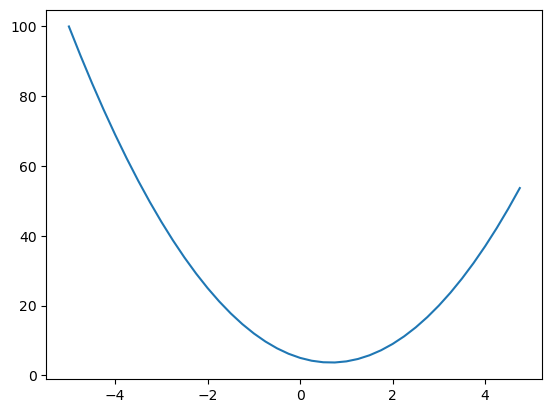

In [7]:
plt.plot(xs, f(xs))

In [8]:
h = 0.001
x = 3.0
(f(x + h) - f(x)) / h

14.00300000000243

In [9]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [10]:
# now deriavtive with respect to a
h = 0.0001
a = a + h
d1 = a * b + c
print(f"Og:{d}, D1:{d1}, slop = {(d1-d)/h}")

Og:4.0, D1:3.999699999999999, slop = -3.000000000010772


In [11]:
class Value:
    def __init__(self, data, _child=(), _op="", label=""):
        self.data = data
        self.grad = 0.0  # no effect at initialisation
        self._backward = lambda: None  # default for a leaf node
        self._prev = set(_child)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return (self*(-1))

    def __sub__(self,other):
        return self + (-other)

    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += out.grad * (other * (self.data ** (other - 1)))
        out._backward = _backward
        return out 

    def __truediv__(self, other):
        return self * (other**-1)

    def tanh(self):
        n = self.data
        t = (np.exp(2 * n) - 1) / (np.exp(2 * n) + 1)
        out = Value(t, (self,), _op="tanh")

        def _backward():
            self.grad += (1 - (t**2)) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.grad * math.exp(x)

        out._backward = _backward
        return out 
    def backward(self):  # back prop
        # Topological sor
        topo =[]
        visited = set()
        # make a topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        # call ._backward on all nodes
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [12]:
a = Value(3)
b = Value(2)

b-a

Value(data=-1)

In [13]:
a = Value(2.0, label="a")
b = Value(-3, label="b")
c = Value(10.0, label="c")
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Value(data=-2, label="f")
l = d * f
l.label = "l"

In [14]:
d._prev, d._op

({Value(data=-6.0), Value(data=10.0)}, '+')

In [15]:
### for curosity and practice
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # Create a node with a label showing data and operation
        dot.node(
            name=uid,
            label=f"{{ {n.label} | data: {n.data:.3f}|grad:{n.grad:.3f} }}",
            shape="record",
        )
        if n._op:
            # Add an operation node
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect nodes
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [16]:
type(d)

__main__.Value

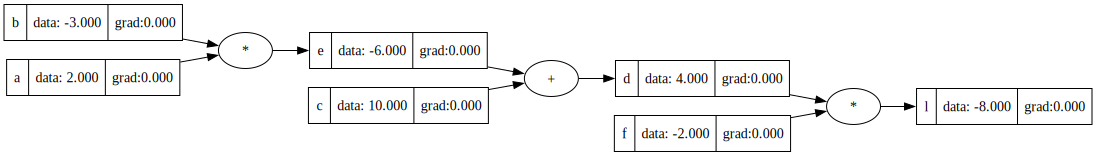

In [17]:
draw_dot(l)

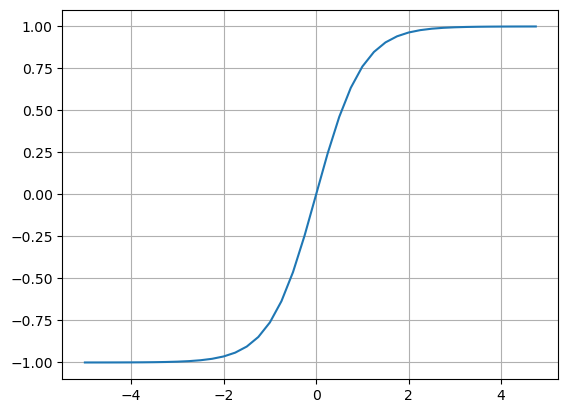

In [18]:
x = np.arange(-5, 5, 0.25)
plt.plot(x, np.tanh(x))
plt.grid()

In [19]:
x1 = Value(2.0, label="x1")
w1 = Value(-3.0, label="w1")
x2 = Value(0.0, label="x2")
w2 = Value(1.0, label="w2")
bias = Value(6.8813, label="B")

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1_x2w2 = x1w1 + x2w2
x1w1_x2w2.label = "x1w1_x2w2"

n = x1w1_x2w2 + bias
n.label = "n"
o = n.tanh()
o.label = "o"

In [20]:
o.backward()

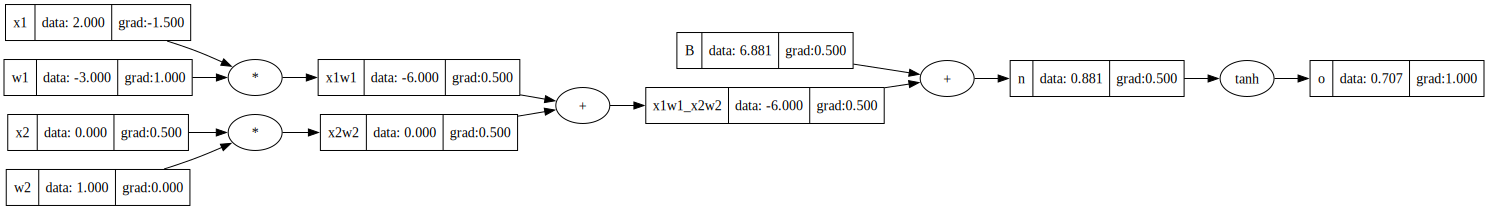

In [21]:
draw_dot(o)

In [22]:
x1 = Value(2.0, label="x1")
w1 = Value(-3.0, label="w1")
x2 = Value(0.0, label="x2")
w2 = Value(1.0, label="w2")
bias = Value(6.8813, label="B")

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1_x2w2 = x1w1 + x2w2
x1w1_x2w2.label = "x1w1_x2w2"

n = x1w1_x2w2 + bias
n.label = "n"
#---
e = (2*n).exp()
o= (e-1)/(e+1)
#---
o.label = "o"

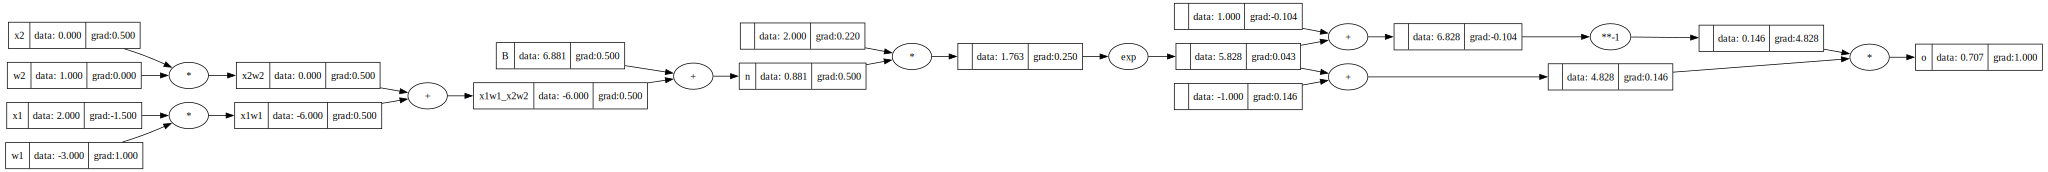

In [23]:
o.backward()
draw_dot(o)

In [294]:
# setting up a neuron
class Neuron :
    def __init__(self,noI): ## here noI is number of inputs to a neuron
        self.w = [Value(random.uniform(-1,1))for _ in range(noI)]
        self.b = Value(random.uniform(-1,1))    

    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out

    def parametrs(self):
        return self.w + [self.b]
        

class Layer:
    def __init__(self,noI,noO):
        self.neurons = [Neuron(noI) for _ in range(noO)]

    def __call__(self,x):
        out = [n(x) for n in (self.neurons)]
        return out[0] if len(out)==1 else out

    def parametrs(self):
        return [p for n in self.neurons for p in n.parametrs() ]

class MLP:
    def __init__(self,noI,noOs): ## noOs is no of output layers in a sequential manner it is a list of layers with each element containing neurons in that particular layer
        sz = [noI] +noOs
        self.layers = [Layer(sz[i],sz[i+1]) for i in range (len(noOs))] # so this is how we creater our sequential arrangement of layers with current layer feeding into the next

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parametrs(self):
        return [p for l in self.layers for p in l.parametrs() ]

m=MLP(3,[4,4,1])




In [289]:
XS = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [3.0,1.0,-1.0],
        
    ]
ys = [1,-1,1,-1]

In [290]:
# writing the trainning loop
epochs = 100
for epoch in range(epochs):
    #forward loss 
    ypred = [m(x) for x in XS]
    loss = sum((yout-y_t)**2 for y_t,yout in zip(ys,ypred))
    #backward pass 
    for p in m.parametrs():
        p.grad=0.0
    loss.backward()
    #update 
    for p in m.parametrs():
        p.data += -0.05 * p.grad

    if epoch%10==0:
        print(f"Epoch:{epoch},Loss:{loss.data:.5f}")
    


Epoch:0,Loss:7.36247
Epoch:10,Loss:0.15703
Epoch:20,Loss:0.04925
Epoch:30,Loss:0.02776
Epoch:40,Loss:0.01900
Epoch:50,Loss:0.01431
Epoch:60,Loss:0.01143
Epoch:70,Loss:0.00948
Epoch:80,Loss:0.00808
Epoch:90,Loss:0.00703


In [291]:
ypred

[Value(data=0.9710267580268985),
 Value(data=-0.9637637022725309),
 Value(data=0.9552395254728256),
 Value(data=-0.9538706475303997)]

In [295]:
xor = [
    [0,0],
    [0,1],
    [1,0],
    [1,1],
]
y=[0,1,1,1]

In [300]:
epochs = 100
for epoch in range(epochs):
    #forward loss 
    ypred = [m(x) for x in xor]
    loss = sum((yout-y_t)**2 for y_t,yout in zip(y,ypred))
    #backward pass 
    for p in m.parametrs():
        p.grad=0.0
    loss.backward()
    #update 
    for p in m.parametrs():
        p.data += -0.05 * p.grad

    if epoch%10==0:
        print(f"Epoch:{epoch},Loss:{loss.data:.5f}")
    

Epoch:0,Loss:0.00242
Epoch:10,Loss:0.00226
Epoch:20,Loss:0.00212
Epoch:30,Loss:0.00200
Epoch:40,Loss:0.00189
Epoch:50,Loss:0.00179
Epoch:60,Loss:0.00170
Epoch:70,Loss:0.00161
Epoch:80,Loss:0.00154
Epoch:90,Loss:0.00147


In [301]:
ypred

[Value(data=0.0018861295299971133),
 Value(data=0.972416536926635),
 Value(data=0.9754910100663379),
 Value(data=0.9930574245023558)]

In [303]:
m([0,0]) , m([0,1])

(Value(data=0.001877666921919188), Value(data=0.9724756830263227))